# Práctica 4 - Clasificación

Nombres:
* Sergio de la Cruz
...

En esta práctica, tendréis que predecir la concesión de créditos de un banco. Tenéis los datasets abajo igual que en la práctica anterior.

Esta vez, obligaremos a subir una submission a la competición de kaggle, con premio especial para:
* Los ganadores de la competición
* Todo aquel que supere la precisión obtenida por los mentores

Podéis encontrar la URL de kaggle (donde se encuentran, entre otras cosas, los criterios de evaluación) aquí:
https://www.kaggle.com/t/9c6fa1489e714d45889b013bd2abd267

Suerte!

In [199]:
train_url = "https://gist.githubusercontent.com/w-dan/5b1d67c4f507b2b826ed90bec372f1a4/raw/24679757c6bf9bcc74ef4d7944196a1f37b93eba/train3.csv"
test_url = "https://gist.githubusercontent.com/w-dan/5b1d67c4f507b2b826ed90bec372f1a4/raw/24679757c6bf9bcc74ef4d7944196a1f37b93eba/test3.csv"

Un consejo para las submissions:

Guardad la columna `ID` al principio, así podéis droppear sin riesgos


```python
df_test = pd.read_csv(test_url)
submission = df_test[['ID']].copy()      # preparamos un dataframe con una columna 'ID'
```


Y ahora, para montar la submission:

```python
mis_predicciones = mi_clasificador.predict(df_test)

# al final del ejercicio, guardamos las predicciones en el dataframe 'submission' que creamos al principio
submission['Credit_Score'] = y_pred_dftest

# si habéis cambiado a números (algunos algoritmos lo requieren) la variable objetivo, revertid los cambios, por ejemplo, asi:
submission.Credit_Score = submission.Credit_Score.replace({0: "Poor", 1: "Standard", 2: "Good"})

```

Para guardarla como csv y subirla a kaggle:

```python
submission.to_csv("./mi_submission.csv", index=False)

# o si usáis google colab, os dejo una forma cómoda de descargar el csv:
from google.colab import files
submission.to_csv('mi_submission.csv', index=False)
files.download('mi_submission.csv')
```

Y directos a la cima del ranking :D


¡Mucha suerte!

In [200]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import re

In [201]:
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [202]:
pd.set_option('display.max_columns', None)

In [203]:
train_df.head(4)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,43161,3985,4,Lawrencez,40.0,856431180.0,Accountant,97384.44,8167.370000,1.0,3.0,8.0,1.0,Debt Consolidation Loan,20.0,12.0,0.52,3.0,Good,405.45,32.643281,336.0,No,77.284943,53.714219,High_spent_Large_value_payments,847.172909,Standard
1,40663,49494,2,Mohammedr,39.0,417453942.0,Writer,31369.58,2607.131667,8.0,9.0,27.0,8.0,"Home Equity Loan, Not Specified, Not Specified...",30.0,25.0,19.70,6.0,Bad,4259.91,39.375507,144.0,Yes,171.748418,44.990811,High_spent_Large_value_payments,280.855383,Standard
2,111059,2925,6,Alistairn,17.0,499528888.0,Writer,30171.86,2772.321667,6.0,7.0,30.0,9.0,"Personal Loan, Home Equity Loan, Home Equity L...",49.0,18.0,23.49,10.0,Bad,3406.51,34.039021,123.0,Yes,205.403926,40.781489,High_spent_Large_value_payments,247.322615,Standard
3,72139,21358,2,Dinesh Naire,22.0,859449371.0,Doctor,13100.02,1246.668333,7.0,5.0,6.0,5.0,"Credit-Builder Loan, Credit-Builder Loan, Not ...",6.0,20.0,10.64,8.0,Standard,727.29,34.747262,129.0,Yes,41.177132,23.005463,Low_spent_Large_value_payments,298.156832,Standard


65000


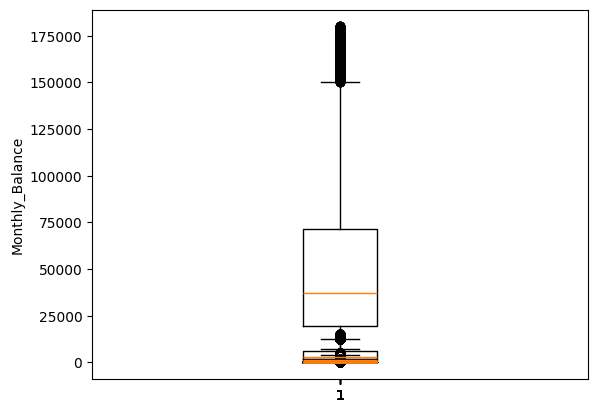

In [204]:
print(train_df.shape[0])
for col in ['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
             'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
               'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 
               'Credit_History_Age', 'Total_EMI_per_month',	'Amount_invested_monthly',	'Monthly_Balance']:# Crear la gráfica de puntos
    plt.boxplot(train_df[col])

    # Agregar etiquetas y título
    plt.ylabel(col)
    # Mostrar la gráfica
    # plt.show()

In [205]:
print(train_df.shape[0])
# train_df[train_df.Customer_ID==1011]
print(train_df[['Customer_ID', 'Credit_Score']].drop_duplicates().shape[0])
print(train_df[['ID', 'Credit_Score']].drop_duplicates().shape[0])

65000
18619
65000


Se puntuan a las cuentas bancarias no a las personas

In [206]:
def onehot_encode(train_df, columns_to_encode):
    # columns_to_encode = ['fuel', 'seller_type', 'owner', 'marca', 'transmission']
    for column in columns_to_encode:
        encoder = OneHotEncoder()
        encoded = encoder.fit_transform(train_df[[column]])
        encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out([column]))
        encoded_df = encoded_df.astype(int)
        train_df = pd.concat([train_df, encoded_df], axis=1)
    return train_df
    # train_df[['engine','RPM','transmission', 'fuel_encode', 'seller_type_encode', 'owner_encode',	'marca_encode']] =train_df[['engine','RPM','transmission_encode', 'fuel_encode', 'seller_type_encode', 'owner_encode',	'marca_encode']].astype(int)
    
def ordinal_encode(train_df, columns_to_encode, encode):
    if encode == None:
            encoder = OrdinalEncoder()
    for column in columns_to_encode:
        if encode != None:
            cat = encode.get(column)
            encoder = OrdinalEncoder(categories=[cat])
        train_df[column+'_encode'] = encoder.fit_transform(train_df[[column]])
        train_df[column+'_encode'] = train_df[column+'_encode'].astype(int)
    return train_df

def type_loan_encode(row):
    loans = row['Type_of_Loan'].replace(' and', '').replace(' ', '_').split(',_')
    for loan in loans:
        row[loan] = 1
    return row

def payment_behaviour_encode(row):
    PB = row['Payment_Behaviour'].split('_')
    row['Payment_Behaviour_spent'] = PB[0]
    row['Payment_Behaviour_value_payments'] = PB[2]
    return row

def encode_rows(row):
    row = payment_behaviour_encode(row)
    row = type_loan_encode(row)
    return row


def preproceso(train_df, encode):

    train_df = train_df.drop_duplicates()
    train_df = train_df.dropna().reset_index(drop=True)
    # train_df = train_df.apply(lambda x: encode_rows(x), axis=1)
    # for col in train_df.columns:
    #     if col.find('_Loan')!=-1:
    #         train_df[col] = train_df[col].fillna(0)
    # train_df['Not_Specified'] = train_df['Not_Specified'].fillna(0)
    # train_df['No_Data'] = train_df['No_Data'].fillna(0)


    train_df.Credit_Mix = train_df.Credit_Mix.replace({"Bad": 0, "Standard": 1, "Good": 2})
    train_df.Credit_Score = train_df.Credit_Score.replace({"Poor": 0, "Standard": 1, "Good": 2})
    # train_df.Payment_Behaviour_spent = train_df.Payment_Behaviour_spent.replace({"High": 0, "Low": 1})
    # train_df.Payment_Behaviour_value_payments = train_df.Payment_Behaviour_value_payments.replace({"Medium": 0, "Large": 1, "Small": 2})
    train_df.Payment_of_Min_Amount = train_df.Payment_of_Min_Amount.replace({"No": 0, "NM": 1, "Yes":2})
    # columns_to_encode = ['Credit_Mix',	'Credit_Score', 'Occupation', 'Payment_Behaviour_spent', 'Payment_Behaviour_value_payments', 'Payment_of_Min_Amount']
    # train_df = onehot_encode(train_df, ['Occupation'])


    train_df = train_df.drop(['Name', 'Type_of_Loan', 'Payment_Behaviour', 'Occupation', 'SSN', 'Customer_ID', 'ID', 'Month'], axis=1)

    return train_df

new_train_df = preproceso(train_df, None)


In [207]:
new_train_df

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score
0,40.0,97384.440,8167.370000,1.0,3.0,8.0,1.0,20.0,12.0,0.52,3.0,2,405.45,32.643281,336.0,0,77.284943,53.714219,847.172909,1
1,39.0,31369.580,2607.131667,8.0,9.0,27.0,8.0,30.0,25.0,19.70,6.0,0,4259.91,39.375507,144.0,2,171.748418,44.990811,280.855383,1
2,17.0,30171.860,2772.321667,6.0,7.0,30.0,9.0,49.0,18.0,23.49,10.0,0,3406.51,34.039021,123.0,2,205.403926,40.781489,247.322615,1
3,22.0,13100.020,1246.668333,7.0,5.0,6.0,5.0,6.0,20.0,10.64,8.0,1,727.29,34.747262,129.0,2,41.177132,23.005463,298.156832,1
4,26.0,62313.540,5120.795000,6.0,2.0,18.0,4.0,27.0,8.0,12.82,9.0,1,817.64,24.545394,122.0,1,196.679642,63.346750,152.669902,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64995,44.0,19795.890,1203.188188,3.0,3.0,12.0,1.0,24.0,17.0,14.71,2.0,1,582.75,27.049585,324.0,2,159.609395,43.165679,286.771047,2
64996,23.0,33624.400,2869.033333,4.0,5.0,20.0,4.0,30.0,9.0,8.80,7.0,1,987.27,38.337145,348.0,1,72.257138,32.825775,421.253518,1
64997,15.0,17057.830,1618.485833,6.0,10.0,24.0,6.0,26.0,20.0,20.72,10.0,0,4832.80,36.584023,60.0,2,65.827966,26.005337,238.070938,0
64998,18.0,125385.880,10720.823333,2.0,5.0,5.0,4.0,17.0,1.0,9.36,1.0,2,1268.57,38.854570,296.0,1,364.360310,168.868471,437.879559,1


In [208]:
study_train_df = new_train_df.astype(int)

study_train_df.Age = study_train_df.Age/10
study_train_df.Amount_invested_monthly	 = study_train_df.Amount_invested_monthly/10
study_train_df.Annual_Income = study_train_df.Annual_Income/10000
study_train_df.Changed_Credit_Limit = study_train_df.Changed_Credit_Limit/10
study_train_df.Credit_History_Age = study_train_df.Credit_History_Age/100
study_train_df.Credit_Utilization_Ratio = study_train_df.Credit_Utilization_Ratio/10
# study_train_df.Customer_ID = study_train_df.Customer_ID/10000
study_train_df.Delay_from_due_date = study_train_df.Delay_from_due_date/10
# study_train_df.ID = study_train_df.ID/10000
study_train_df.Interest_Rate = study_train_df.Interest_Rate/10
study_train_df.Monthly_Balance = study_train_df.Monthly_Balance/100
study_train_df.Monthly_Inhand_Salary = study_train_df.Monthly_Inhand_Salary/1000
study_train_df.Num_of_Delayed_Payment = study_train_df.Num_of_Delayed_Payment/10
study_train_df.Outstanding_Debt = study_train_df.Outstanding_Debt/1000
study_train_df.Total_EMI_per_month = study_train_df.Total_EMI_per_month/1000

study_train_df = study_train_df.astype(int)
study_train_df

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score
0,4,9,8,1,3,0,1,2,1,0,3,2,0,3,3,0,0,5,8,1
1,3,3,2,8,9,2,8,3,2,1,6,0,4,3,1,2,0,4,2,1
2,1,3,2,6,7,3,9,4,1,2,10,0,3,3,1,2,0,4,2,1
3,2,1,1,7,5,0,5,0,2,1,8,1,0,3,1,2,0,2,2,1
4,2,6,5,6,2,1,4,2,0,1,9,1,0,2,1,1,0,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64995,4,1,1,3,3,1,1,2,1,1,2,1,0,2,3,2,0,4,2,2
64996,2,3,2,4,5,2,4,3,0,0,7,1,0,3,3,1,0,3,4,1
64997,1,1,1,6,10,2,6,2,2,2,10,0,4,3,0,2,0,2,2,0
64998,1,12,10,2,5,0,4,1,0,0,1,2,1,3,2,1,0,16,4,1


In [209]:
print(study_train_df.Credit_Score.mean())
for col in new_train_df.columns.difference(['Name', 'Type_of_Loan', 'Occupation', 'SSN', 'Credit_Score']):
    print(pd.DataFrame(study_train_df.groupby(col)['Credit_Score'].mean()))

0.8881538461538462
     Credit_Score
Age              
1        0.701923
2        0.854935
3        0.860943
4        0.932483
5        1.219626
                         Credit_Score
Amount_invested_monthly              
0                            0.603728
1                            0.717363
2                            0.832836
3                            0.848504
4                            0.832579
5                            0.899894
6                            0.901491
7                            0.973665
8                            1.000348
9                            1.013861
10                           1.069277
11                           1.075988
12                           1.059813
13                           1.245007
14                           1.184211
15                           1.126338
16                           1.230958
17                           1.140288
18                           1.164773
19                           1.375000
20                 

In [210]:
from sklearn import metrics

def evalua(y_test, data_pred):
    print("Accuracy:", metrics.accuracy_score(y_test, data_pred))
    print("F1:", metrics.f1_score(y_test, data_pred, average='weighted'))
    cm =  metrics.confusion_matrix(y_test, data_pred)
    plt.figure(figsize=[3,3])
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [211]:
n_fit=int(train_df.shape[0]*0.9)

X = new_train_df

X_train = X[X.columns.drop('Credit_Score')][:n_fit]
y_train = X['Credit_Score'][:n_fit]
X_test = X[X.columns.drop('Credit_Score')][n_fit:]
y_test = X['Credit_Score'][n_fit:]

Accuracy: 0.7350769230769231
F1: 0.7347128293892475


<Figure size 300x300 with 0 Axes>

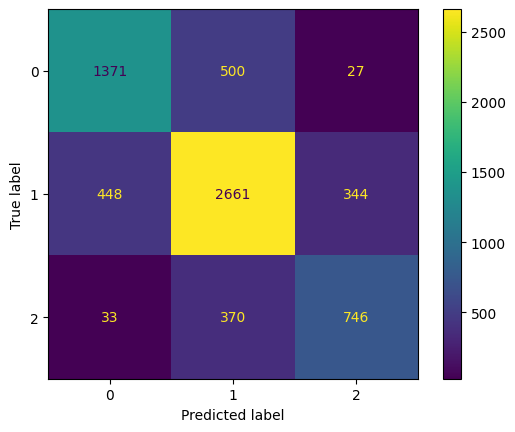

In [212]:
from sklearn.tree import DecisionTreeClassifier

arbol = DecisionTreeClassifier()
arbol = arbol.fit(X_train,y_train)
data_pred = arbol.predict(X_test)
evalua(y_test, data_pred)

Accuracy: 0.7361538461538462
F1: 0.734300837333875


<Figure size 300x300 with 0 Axes>

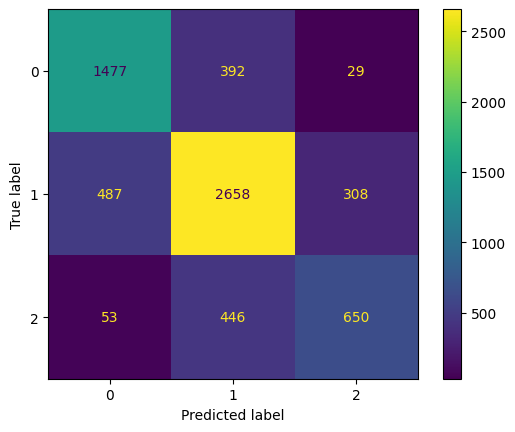

In [213]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier().fit(X_train,y_train)
data_pred = classifier.predict(X_test)

evalua(y_test, data_pred)


Probar XGBoost

Accuracy: 0.7666153846153846
F1: 0.7667943072445756


<Figure size 300x300 with 0 Axes>

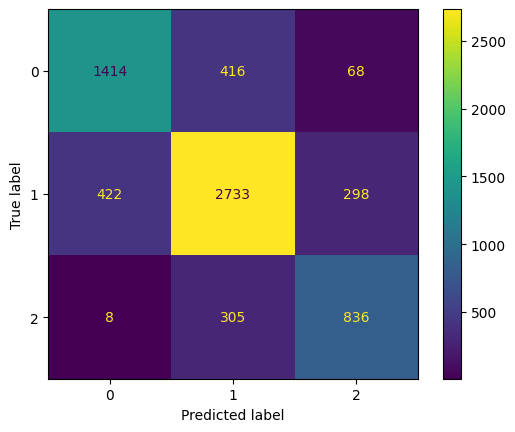

In [214]:
from xgboost import XGBClassifier

data_pred = XGBClassifier().fit(X_train, y_train).predict(X_test)
evalua(y_test, data_pred)
